In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
import api_keys
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
import requests
from scipy.stats import anderson
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [3]:
# Importing the index
df = pd.read_csv("results\BTCTSI.csv")
df = df.set_index('date')
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

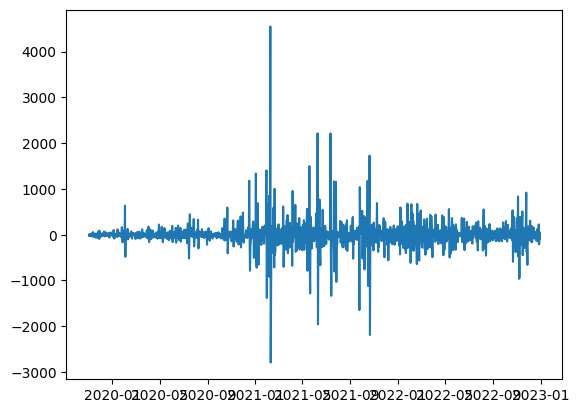

In [4]:
plt.plot(df.compound -df.compound.shift(1))

c:\Users\tomma\OneDrive\Desktop\Work\Paper_1\paper1_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\tomma\OneDrive\Desktop\Work\Paper_1\paper1_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\tomma\OneDrive\Desktop\Work\Paper_1\paper1_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               compound   No. Observations:                 1156
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -8289.828
Date:                Fri, 03 Mar 2023   AIC                          16583.655
Time:                        16:47:58   BIC                          16593.759
Sample:                    11-01-2019   HQIC                         16587.468
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2837      0.009    -31.102      0.000      -0.302      -0.266
sigma2      1.005e+05    842.799    119.208      0.000    9.88e+04    1.02e+05
Ljung-Box (L1) (Q):                   4.87   Jarque-

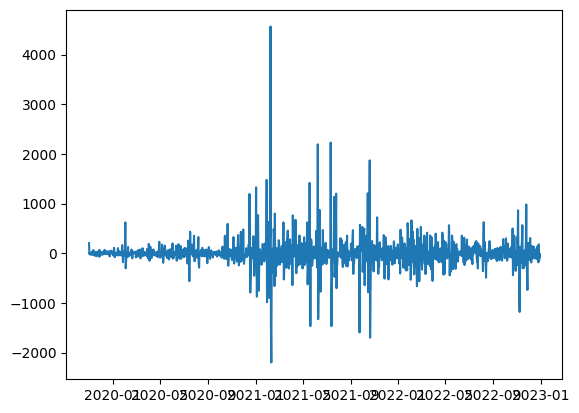

In [5]:
# Checking for stationarity
# Fit an AR(2) model
model = ARIMA(df['compound'], order=(1, 1, 0))
results = model.fit()
print(results.summary())
# Perform the Augmented Dickey-Fuller (ADF) test
plt.plot(results.resid)
result = adfuller(results.resid)
print("ADF test statistic: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])


In [6]:
# Getting btc data
start = df.index[0]
end = df.index[-1]
start_day = start.strftime('%Y-%m-%d')
end_day = end.strftime('%Y-%m-%d')

# Getting data
data = yf.download('BTC-USD', start=start, end='2022-12-31')

[*********************100%***********************]  1 of 1 completed


In [7]:
# getting Fear and Greed data
r = requests.get("https://api.alternative.me/fng/?limit=0")
FG = pd.DataFrame(r.json()['data'])
FG.value = FG.value.astype(int)
FG.timestamp = pd.to_datetime(FG.timestamp, unit = 's')
FG.set_index('timestamp', inplace= True)

In [29]:
result = pd.merge(df, FG, left_index=True, right_index = True)
result.corr()


C:\Users\tomma\AppData\Local\Temp\ipykernel_9128\1310451130.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  result.corr()


,compound,volume,value
compound,1.000000,0.460879,0.345459
volume,0.460879,1.000000,-0.125735
value,0.345459,-0.125735,1.000000


In [19]:
len(df), len(data)

(1156, 1156)

In [8]:
# getting t-bill rate
# Create a connection to the FRED API
fred = Fred(api_key=api_keys.fred_key)
# Retrieve daily data for the 1-year Treasury Bill rate between a specific date range
tb_data = fred.get_series('DGS1',observation_start=start,observation_end=end)

In [9]:
data['risk_free'] = tb_data

In [10]:
volumes = pd.DataFrame({'sentiment':df['volume']})
volumes['BTC'] = data.Volume.values

In [11]:
volumes[0:200].corr()

,sentiment,BTC
sentiment,1.000000,0.609386
BTC,0.609386,1.000000


In [12]:
df['btctsi'] = (df.compound - df.compound.mean())/df.compound.std()
df.describe()

,compound,volume,btctsi
count,1156.000000,1156.000000,1.156000e+03
mean,441.352598,8704.036332,-1.229313e-16
std,429.817191,5096.102013,1.000000e+00
min,-841.152600,650.000000,-2.983839e+00
25%,193.712100,3926.000000,-5.761531e-01
50%,336.141550,8907.000000,-2.447809e-01
75%,662.990625,11221.500000,5.156565e-01
max,5264.470400,56179.000000,1.122132e+01


In [7]:
skew(df, axis = 0, bias=True)

array([2.48275483, 1.63086568, 2.48275483])

In [10]:
df.head()

,compound,volume,btctsi
date,,,
2019-11-01,203.2874,2549,-0.553875
2019-11-02,178.3068,2301,-0.611995
2019-11-03,191.2831,2369,-0.581804
2019-11-04,167.4784,2685,-0.637188
2019-11-05,184.9700,2625,-0.596492


In [14]:
data['Mom'] = data.Close - data.Open
data['Mom_L1'] = data.Mom.shift()
data['Mom_2'] = data.Close.diff(2)
data['Mom_2_L1'] = data.Close.shift()
data['Ret'] = data.Close.pct_change() - (data.risk_free/100)/365
data['Ret_L1'] = data.Ret.shift()
data['Volume_L1'] = data.Volume.shift()
data['BiTSI'] = df.btctsi
data['BiTSI_L1'] = data.BiTSI.shift()
data['BiTSI_L2'] = data.BiTSI.shift(2)
data['NBiTSI'] = (df.compound/df.volume) 
data['NBiTSI_L1'] = data.NBiTSI.shift()
data['NBiTSI_L2'] = data.NBiTSI.shift(2)


In [22]:
df_plot = data.loc[:,['NBiTSI','Ret', 'Ret_L1', 'Mom','Mom_L1','Mom_2', 'Mom_2_L1','Volume','Volume_L1']]

In [16]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,risk_free,Mom,Mom_L1,Mom_2,...,BTCTSI_L2,NBTCTSI,NBTCTSI_L1,NBTCTSI_L2,BiTSI,BiTSI_L1,BiTSI_L2,NBiTSI,NBiTSI_L1,NBiTSI_L2
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,9193.992188,9275.657227,9132.047852,9261.104492,9261.104492,24324691031,1.53,67.112305,NaN,NaN,...,NaN,0.079752,NaN,NaN,-0.553875,NaN,NaN,0.079752,NaN,NaN
2019-11-02,9259.783203,9377.486328,9249.587891,9324.717773,9324.717773,21242676385,NaN,64.934570,67.112305,NaN,...,NaN,0.077491,0.079752,NaN,-0.611995,-0.553875,NaN,0.077491,0.079752,NaN
2019-11-03,9324.787109,9379.806641,9141.251953,9235.354492,9235.354492,21132220847,NaN,-89.432617,64.934570,-25.750000,...,-0.553875,0.080744,0.077491,0.079752,-0.581804,-0.611995,-0.553875,0.080744,0.077491,0.079752
2019-11-04,9235.607422,9505.051758,9191.485352,9412.612305,9412.612305,26170255634,1.56,177.004883,-89.432617,87.894531,...,-0.611995,0.062376,0.080744,0.077491,-0.637188,-0.581804,-0.611995,0.062376,0.080744,0.077491
2019-11-05,9413.004883,9457.417969,9256.931641,9342.527344,9342.527344,26198609048,1.62,-70.477539,177.004883,107.172852,...,-0.581804,0.070465,0.062376,0.080744,-0.596492,-0.637188,-0.581804,0.070465,0.062376,0.080744


In [14]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
df_plot.loc[:,['NBTCTSI','Ret','Mom','Volume']].describe()

,NBTCTSI,Ret,Mom,Volume
count,1116.0000,763.0000,1117.0000,1117.0000
mean,0.0594,0.0017,1.9885,36521731892.1370
std,0.0350,0.0422,1260.5946,18777844667.4853
min,-0.0504,-0.3717,-7563.9961,12252601475.0000
25%,0.0401,-0.0175,-346.7500,24957448100.0000
50%,0.0638,0.0003,9.1836,32722975141.0000
75%,0.0830,0.0217,358.7344,43137459378.0000
max,0.2580,0.1875,7309.6367,350967941479.0000


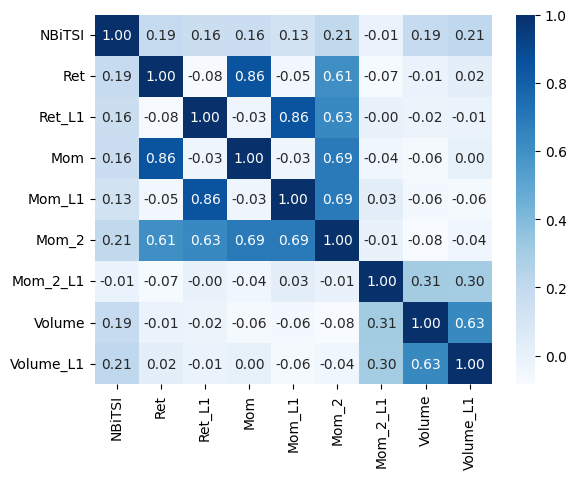

In [23]:
# plot the heatmap
svm = sns.heatmap(df_plot.corr(), 
        cmap="Blues", annot=True, fmt='.2f')

In [21]:
figure = svm.get_figure()    
figure.savefig('svm_conf_N.png', dpi=600, bbox_inches = 'tight')